### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/6_SentModels

Mounted at /gdrive
/gdrive/My Drive/Progetto AN2DL/6_SentModels


### Import libraries

In [2]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle
from tqdm import tqdm

### Load and process the dataset

In [5]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save labels in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [6]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

### ConvNeXtLarge

In [7]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

785596384/785596384 [==============================] - 29s 0us/step


### Initial setup

In [8]:
# Define network parameters/callbacks
dropout_rate = 1/10
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.99,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True
)

In [9]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

### K-Fold + Transfer Learning

In [10]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(images, labels)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Init model
  k_model = build_model(feature_extractor, dropout_rate, learning_rate)
  train_datagen = ImageDataGenerator(
          horizontal_flip = True,
          vertical_flip = True,
          width_shift_range = 0.1,
          height_shift_range = 0.1,
          rotation_range=10.,
          brightness_range=(0.9,1.1),
          fill_mode='reflect')

  train_datagen.fit((images)[train_idx]*255)

  # Train the model on the training data for this fold
  history = k_model.fit_generator(
      train_datagen.flow((images)[train_idx]*255, labels[train_idx], batch_size=16),
      epochs=200,
      steps_per_epoch=len((images)[train_idx])/16,
      validation_data = ((images)[valid_idx]*255, labels[valid_idx]),
      callbacks = [early_stopping, lr_scheduler]
      ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate((images)[valid_idx]*255, labels[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - 15
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

Starting training on fold num: 1
Epoch 1/200
281/281 [==============================] - 62s 119ms/step - loss: 0.4956 - accuracy: 0.7715 - val_loss: 0.3443 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 19s 67ms/step - loss: 0.3839 - accuracy: 0.8308 - val_loss: 0.3935 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 20s 70ms/step - loss: 0.3374 - accuracy: 0.8541 - val_loss: 0.2982 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 19s 68ms/step - loss: 0.3165 - accuracy: 0.8641 - val_loss: 0.3627 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 19s 67ms/step - loss: 0.3028 - accuracy: 0.8699 - val_loss: 0.3479 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 20s 69ms/step - loss: 0.2935 - accuracy: 0.8772 - val_loss: 0.2450 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/200
281/28

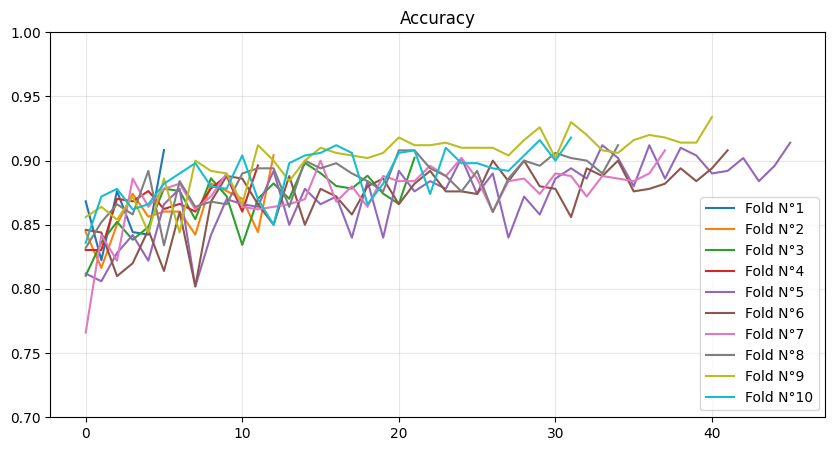

In [20]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(10,5))

# Create a figure for Validation visualization
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'][:-15], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.ylim(0.7, 1.0)
  plt.title('Accuracy')
  plt.legend(loc='lower right')
  plt.grid(alpha=.3)

# Show the plot
plt.show()

In [12]:
# Calculate the average best epoch
print (best_epochs)
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

[6, 13, 22, 12, 46, 42, 38, 35, 41, 32]
Best average epoch: 28


In [13]:
# Build the final model using the calculated average best epoch
final_model = build_model(feature_extractor, dropout_rate, learning_rate)
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range=10.,
        brightness_range=(0.9,1.1),
        fill_mode='reflect')

train_datagen.fit(images*255)

# Train the final model on the combined training and validation data
final_history = final_model.fit_generator(
      train_datagen.flow((images)*255, labels, batch_size=16),
      epochs=avg_epochs,
      steps_per_epoch=len(images)/16,
      validation_data = ((images)*255, labels),
      callbacks = [ lr_scheduler]
      ).history

Epoch 1/28
312/312 [==============================] - 57s 134ms/step - loss: 0.4984 - accuracy: 0.7624 - val_loss: 0.3367 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 2/28
312/312 [==============================] - 32s 102ms/step - loss: 0.3695 - accuracy: 0.8325 - val_loss: 0.3609 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 3/28
312/312 [==============================] - 32s 103ms/step - loss: 0.3365 - accuracy: 0.8543 - val_loss: 0.2744 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 4/28
312/312 [==============================] - 32s 103ms/step - loss: 0.3148 - accuracy: 0.8637 - val_loss: 0.2634 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 5/28
312/312 [==============================] - 32s 104ms/step - loss: 0.2820 - accuracy: 0.8767 - val_loss: 0.2965 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 6/28
312/312 [==============================] - 32s 102ms/step - loss: 0.2914 - accuracy: 0.8735 - val_loss: 0.2752 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 7/28
312/312 [==============================] 

In [14]:
# Save the model
final_model.save('3thSubmission_TL')
with open('3thSubmission_TL/history.pkl', 'wb') as f:
  pickle.dump(final_history, f)

### Fine Tuning

In [10]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(images, labels)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Init model
  k_model = tfk.models.load_model('3thSubmission_TL')
  train_datagen = ImageDataGenerator(
          horizontal_flip = True,
          vertical_flip = True,
          width_shift_range = 0.1,
          height_shift_range = 0.1,
          rotation_range=10.,
          brightness_range=(0.9,1.1),
          fill_mode='reflect')

  train_datagen.fit((images)[train_idx]*255)

  # Set all ConvNeXtLarge layers as trainable
  k_model.get_layer('convnext_large').trainable = True
  for i, layer in enumerate(k_model.get_layer('convnext_large').layers):
    print(i, layer.name, layer.trainable)

  # Freeze first N layers, e.g., until the 133rd one
  N = 286
  for i, layer in enumerate(k_model.get_layer('convnext_large').layers[:N]):
    layer.trainable=False
  for i, layer in enumerate(k_model.get_layer('convnext_large').layers):
    print(i, layer.name, layer.trainable)
  k_model.summary()

  # Compile the model
  k_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(learning_rate),
                  metrics='accuracy')

  # Train the model on the training data for this fold
  history = k_model.fit_generator(
      train_datagen.flow((images)[train_idx]*255, labels[train_idx], batch_size=16),
      epochs=200,
      steps_per_epoch=len((images)[train_idx])/16,
      validation_data = ((images)[valid_idx]*255, labels[valid_idx]),
      callbacks = [early_stopping, lr_scheduler]
      ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate((images)[valid_idx]*255, labels[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - 15
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

Streaming output truncated to the last 5000 lines.
48 convnext_large_stage_1_block_2_pointwise_conv_2 False
49 convnext_large_stage_1_block_2_layer_scale False
50 convnext_large_stage_1_block_2_identity False
51 tf.__operators__.add_5 False
52 convnext_large_downsampling_block_1 False
53 convnext_large_stage_2_block_0_depthwise_conv False
54 convnext_large_stage_2_block_0_layernorm False
55 convnext_large_stage_2_block_0_pointwise_conv_1 False
56 convnext_large_stage_2_block_0_gelu False
57 convnext_large_stage_2_block_0_pointwise_conv_2 False
58 convnext_large_stage_2_block_0_layer_scale False
59 convnext_large_stage_2_block_0_identity False
60 tf.__operators__.add_6 False
61 convnext_large_stage_2_block_1_depthwise_conv False
62 convnext_large_stage_2_block_1_layernorm False
63 convnext_large_stage_2_block_1_pointwise_conv_1 False
64 convnext_large_stage_2_block_1_gelu False
65 convnext_large_stage_2_block_1_pointwise_conv_2 False
66 convnext_large_stage_2_block_1_layer_scale False
6

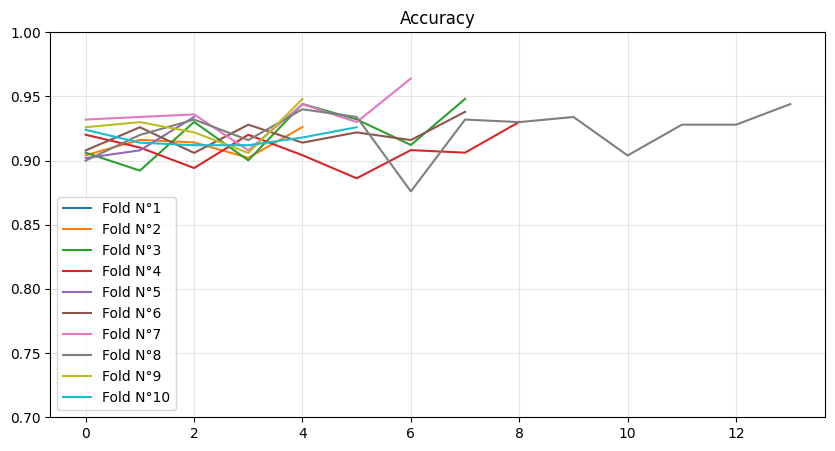

In [11]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(10,5))
# Create a figure for Validation visualization
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'][:-15], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.ylim(0.7, 1.0)
  plt.title('Accuracy')
  plt.legend(loc='lower left')
  plt.grid(alpha=.3)

# Show the plot
plt.show()

In [12]:
# Calculate the average best epoch
print (best_epochs)
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

[1, 5, 8, 9, 3, 8, 7, 14, 5, 6]
Best average epoch: 6


In [13]:
# Build the final model using the calculated average best epoch
final_model = tfk.models.load_model('3thSubmission_TL')
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range=10.,
        brightness_range=(0.9,1.1),
        fill_mode='reflect')

train_datagen.fit((images)*255)

# Set all ConvNeXtLarge layers as trainable
final_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(final_model.get_layer('convnext_large').layers):
  print(i, layer.name, layer.trainable)

# Freeze first N layers, e.g., until the 133rd one
N = 286
for i, layer in enumerate(final_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(final_model.get_layer('convnext_large').layers):
  print(i, layer.name, layer.trainable)
final_model.summary()

# Compile the model
final_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics='accuracy')

# Train the final model on the combined training and validation data
final_history = final_model.fit_generator(
      train_datagen.flow((images)*255, labels, batch_size=16),
      epochs=avg_epochs,
      steps_per_epoch=len(images)/16,
      validation_data = ((images)*255, labels),
      callbacks = [lr_scheduler]
      ).history

0 input_1 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_pointwis

In [14]:
# Save the model
final_model.save('3thSubmission_FT')
with open('3thSubmission_FT/history.pkl', 'wb') as f:
  pickle.dump(final_history, f)